In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from gym.envs.registration import register
import random as rd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
from collections import deque

In [2]:
env = gym.make('CartPole-v1', render_mode = 'rgb_array')

In [3]:
env.action_space.n, env.observation_space.shape[0]

(2, 4)

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
class DQN(nn.Module):
    def __init__(self, lr):
        super(DQN, self).__init__()
        
        self.lr = lr
        self.memory = []
        self.fc1 = nn.Linear(env.observation_space.shape[0],256)
        self.fc2 = nn.Linear(256,256)
        self.fc3 = nn.Linear(256,env.action_space.n)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return self.fc3(x)
    
class memory:
    def __init__(self, capacity):
        self.memory = deque([], maxlen = capacity)
    
    def push(self, arr):
        self.memory.append(arr)

    def get_mini_batch(self, batch_size):
        return rd.sample(self.memory,batch_size)
    def __len__(self):
        return len(self.memory)
    
def get_action(obs, eps, model: DQN):
    with torch.no_grad():
        model.eval()
        Qs = model(torch.tensor(obs).to(device))
        if np.random.random() > eps:
            action = np.argmax(Qs.cpu().detach().numpy())
        else:
            action = np.random.randint(0,env.action_space.n)
    return action

def optimization(target_model, policy_model, memory, batch_size):
    global d_factor
    criterion = nn.MSELoss().to(device)
    optimizer = optim.Adam(policy_model.parameters(), lr = policy_model.lr)

    if len(memory) < batch_size:
        return
    else:
        batch = memory.get_mini_batch(batch_size)
    
    # print((d_factor * target_model(torch.stack([batch[i][2] for i in range(batch_size)]).to(device))).size())
    y_hat = policy_model(torch.stack([batch[i][0] for i in range(batch_size)]).to(device)).max(1)[0]
    with torch.no_grad():
        y = d_factor * target_model(torch.stack([batch[i][2] for i in range(batch_size)]).to(device)).max(1)[0] + torch.stack([batch[i][3] for i in range(batch_size)]).to(device)
    
    cost = criterion(y.to(device), y_hat.to(device))
    cost.backward()
    optimizer.step()



https://tutorials.pytorch.kr/intermediate/reinforcement_q_learning.html

In [6]:
batch_size = 256
gamma = 0.99
epochs = 50000
d_factor = 0.95
eps_decay = 0.99995
eps = 1
lr = 0.1
train_start_epoch = 10000

In [7]:
policy_model = DQN(lr = 0.001).to(device)
target_model = DQN(lr = 0.001).to(device)
target_model.load_state_dict(policy_model.state_dict())

<All keys matched successfully>

In [8]:
timelist = [0]
epslist = []
memory = memory(10000)

for epoch in range(epochs):
    
    observation = env.reset()[0]
    done = False
    time = 0
    
    while not done:
        time += 1
        action = get_action(observation, eps, policy_model)
        new_observation, reward, done, _, _ =  env.step(action)
        memory.push(tuple(map(torch.tensor,(observation, action, new_observation, reward))))
        observation = new_observation
    
    optimization(target_model, policy_model, memory, batch_size)
    
    if timelist[-1] > time and epoch > 5000:
        eps = math.pow(eps_decay, epoch - 5000)
    timelist.append(time)
    epslist.append(eps)
    if (epoch+1) % 1000 == 0:
        print(epoch, time) 

c:\Users\dkstn\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


999 16
1999 79
2999 47
3999 13
4999 18
5999 13
6999 14
7999 17
8999 9
9999 17
10999 16
11999 36
12999 19
13999 17
14999 22
15999 15
16999 24
17999 10
18999 12
19999 12
20999 15
21999 12
22999 10
23999 9
24999 13
25999 17
26999 15
27999 19
28999 9
29999 13
30999 13
31999 10
32999 11
33999 10
34999 10
35999 9
36999 9
37999 10
38999 10
39999 11
40999 10
41999 9
42999 10
43999 12
44999 9
45999 12
46999 12
47999 11
48999 10
49999 10


In [9]:
model = DQN(lr = 0.001).to(device)
target_model = DQN(lr = 0.001).to(device)

criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(model.parameters(), lr = model.lr)
timelist = [0]
epslist = []

for epoch in range(epochs):
    
    observation = env.reset()[0]
    done = False
    time = 0
    
    while not done:
        time += 1
        Qs = model(torch.tensor(observation).to(device))
        if np.random.random() > eps:
            action = np.argmax(Qs.cpu().detach().numpy())
        else:
            action = np.random.randint(0,env.action_space.n)
        new_observation, reward, done, _, _ =  env.step(action)
        Qnext = model(torch.tensor(new_observation).to(device))
        
        if done:
            y_hat = -100
        else:
            y_hat = reward + d_factor * np.argmax(Qnext.cpu().detach().numpy())
        # print(observation,  y)
        # print(Qs.type(),  torch.tensor(y).type())
        cost = criterion(Qs, torch.tensor(y_hat).to(device).float())
        cost.backward()
        optimizer.step()
        observation = new_observation
    
    if timelist[-1] > time and epoch > 5000:
        eps = math.pow(eps_decay, epoch - 5000)
    timelist.append(time)
    epslist.append(eps)
    if (epoch+1) % 1000 == 0:
        print(epoch, time) 

c:\Users\dkstn\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


999 82
1999 25
2999 12
3999 28
4999 11
5999 10
6999 18
7999 13
8999 17
9999 26
10999 31
11999 19
12999 10
13999 33
14999 13
15999 18
16999 28
17999 14
18999 22
19999 22
20999 22
21999 21
22999 13
23999 13
24999 18
25999 18
26999 18
27999 41
28999 20
29999 12
30999 40
31999 20
32999 28
33999 12
34999 15
35999 17
36999 29
37999 9
38999 10
39999 10
40999 19
41999 8
42999 19
43999 21
44999 10
45999 28
46999 85
47999 12
48999 31
49999 22


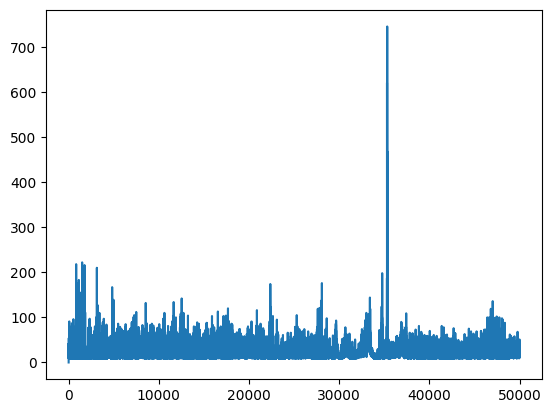

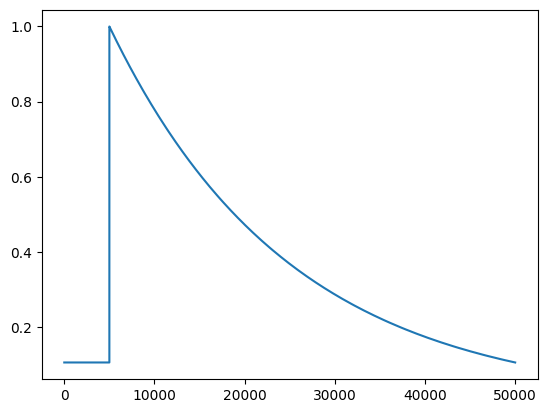

In [10]:
import matplotlib.pyplot as plt

plt.plot(range(len(timelist)),timelist)
plt.show()
plt.plot(range(len(epslist)),epslist)